In [ ]:
####### BASE TRAINING CODE RUNNING WITH VISUALIZATION ###########

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import time
import os
import gc
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from einops import rearrange
import random
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.image import StructuralSimilarityIndexMeasure

# Import custom modules (assumed to be in the same directory)
from Conv3d_patch import SpectralSpatialConv3D
from gssa_attention_module import GSSA
from dense3D import ResidualConv3DProgressiveRefinement

def spectral_angle_mapper(y_true, y_pred, eps=1e-8):
    """Compute Spectral Angle Mapper (SAM) loss between true and predicted spectra."""
    y_true_norm = y_true / (torch.norm(y_true, dim=-1, keepdim=True) + eps)
    y_pred_norm = y_pred / (torch.norm(y_pred, dim=-1, keepdim=True) + eps)
    cos_sim = torch.clamp(torch.sum(y_true_norm * y_pred_norm, dim=-1), -1.0, 1.0)
    sam = torch.acos(cos_sim).mean()
    return sam

def compute_psnr(y_true, y_pred, max_pixel=None):
    """Compute Peak Signal-to-Noise Ratio (PSNR)."""
    # Validate max_pixel based on input data range
    if max_pixel is None:
        max_pixel = torch.max(torch.abs(y_true)).item()
        if max_pixel == 0:
            max_pixel = 1.0  # Fallback to 1.0 if data range is zero
    mse = torch.mean((y_true - y_pred) ** 2)
    if mse == 0:
        return 100.0  # Return large finite value instead of inf
    return 20 * torch.log10(max_pixel / torch.sqrt(mse)).item()

def compute_ssim(y_true, y_pred, device, data_range=1.0):
    """Compute Structural Similarity Index (SSIM)."""
    ssim_metric = StructuralSimilarityIndexMeasure(data_range=data_range).to(device)
    return ssim_metric(y_true, y_pred).item()

def compute_sam_np(y_true, y_pred, eps=1e-8):
    """Compute SAM metric for numpy arrays."""
    y_true_norm = y_true / (np.linalg.norm(y_true, axis=-1, keepdims=True) + eps)
    y_pred_norm = y_pred / (np.linalg.norm(y_pred, axis=-1, keepdims=True) + eps)
    cos_sim = np.clip(np.sum(y_true_norm * y_pred_norm, axis=-1), -1.0, 1.0)
    sam = np.mean(np.arccos(cos_sim))
    return sam

class HSIDenoisingDataset(Dataset):
    """Dataset for HSI denoising with normalization and augmentation."""
    
    def __init__(self, noisy_patches, clean_patches, augment=True, flip_prob=0.5, shuffle_prob=0.3):
        """
        Args:
            noisy_patches: Tensor of shape (N, 1, H, W, D) - noisy input patches
            clean_patches: Tensor of shape (N, 1, H, W, D) - clean ground truth patches
            augment: Whether to apply data augmentation
            flip_prob: Probability of spatial flips
            shuffle_prob: Probability of spectral band shuffling
        """
        self.noisy_patches = noisy_patches
        self.clean_patches = clean_patches
        self.augment = augment
        self.flip_prob = flip_prob
        self.shuffle_prob = shuffle_prob
        
        # Validate dimensions
        assert noisy_patches.shape == clean_patches.shape, \
            f"Shape mismatch: noisy {noisy_patches.shape} vs clean {clean_patches.shape}"
        
        # Normalize patches to [0, 1]
        self.noisy_patches = self._normalize(self.noisy_patches)
        self.clean_patches = self._normalize(self.clean_patches)
    
    def _normalize(self, patches):
        """Normalize patches to [0, 1] using min-max scaling."""
        min_val = torch.amin(patches, dim=(0, 1, 2, 3), keepdim=True)
        max_val = torch.amax(patches, dim=(0, 1, 2, 3), keepdim=True)
        return (patches - min_val) / (max_val - min_val + 1e-8)
    
    def _augment(self, noisy, clean):
        """Apply data augmentation: spatial flips and spectral band shuffling."""
        if not self.augment:
            return noisy, clean
        
        # Random horizontal flip
        if random.random() < self.flip_prob:
            noisy = torch.flip(noisy, dims=[2])
            clean = torch.flip(clean, dims=[2])
        
        # Random vertical flip
        if random.random() < self.flip_prob:
            noisy = torch.flip(noisy, dims=[3])
            clean = torch.flip(clean, dims=[3])
        
        # Random spectral band shuffling
        if random.random() < self.shuffle_prob:
            indices = torch.randperm(noisy.shape[-1])
            noisy = noisy[..., indices]
            clean = clean[..., indices]
        
        return noisy, clean
    
    def __len__(self):
        return len(self.noisy_patches)
    
    def __getitem__(self, idx):
        noisy, clean = self.noisy_patches[idx], self.clean_patches[idx]
        if self.augment:
            noisy, clean = self._augment(noisy, clean)
        return noisy, clean

class HSIDenoisingPipeline(nn.Module):
    """Complete HSI Denoising Pipeline combining Conv3D, GSSA, and Dense3D."""
    
    def __init__(self, conv3d_channels=64, spectral_bands=191, dropout=0.1, use_residual=True):
        """
        Args:
            conv3d_channels: Number of channels in Conv3D feature extractor
            spectral_bands: Number of spectral bands
            dropout: Dropout rate
            use_residual: Whether to add residual connection to input
        """
        super(HSIDenoisingPipeline, self).__init__()
        self.use_residual = use_residual
        
        # Stage 1: Conv3D Feature Extraction
        self.conv3d_extractor = SpectralSpatialConv3D(
            in_channels=1, 
            out_channels=conv3d_channels, 
            dropout=0.2
        )
        
        # Stage 2: GSSA Attention Mechanism
        self.gssa_attention = GSSA(
            channel=conv3d_channels,
            num_bands=spectral_bands,
            flex=False
        )
        
        # Stage 3: Progressive Refinement and Denoising
        self.progressive_denoiser = ResidualConv3DProgressiveRefinement(
            in_channels=conv3d_channels,
            out_channels=1,
            dropout=dropout,
            use_groupnorm=True
        )
    
    def forward(self, x):
        """
        Forward pass through the pipeline.
        
        Args:
            x: Input tensor of shape (B, 1, H, W, D) - noisy HSI patches
            
        Returns:
            denoised: Output tensor of shape (B, 1, H, W, D) - denoised patches
            attention_maps: Attention weights from GSSA
        """
        # Stage 1: Conv3D Feature Extraction
        conv3d_features = self.conv3d_extractor(x)  # (B, C, H, W, D)
        
        # Stage 2: GSSA Attention Processing
        gssa_features, attention_maps = self.gssa_attention(conv3d_features)  # (B, C, H, W, D)
        
        # Stage 3: Progressive Refinement
        denoised = self.progressive_denoiser(conv3d_features, gssa_features)  # (B, 1, H, W, D)
        
        # Residual connection
        if self.use_residual:
            denoised = x + denoised
        
        return denoised, attention_maps

class HSIDenoisingTrainer:
    """Complete HSI Denoising Training Pipeline."""
    
    def __init__(self, 
                 noisy_mat_path,
                 clean_mat_path,
                 device='auto',
                 learning_rate=1e-3,
                 batch_size=8,
                 num_epochs=100,
                 patch_key='patches',
                 clean_patch_key='patches',
                 save_dir='./trained_models',
                 conv3d_channels=64,
                 dropout=0.1,
                 mse_weight=1.0,
                 sam_weight=0.1,
                 early_stopping_patience=10,
                 val_split=0.2):
        """
        Args:
            noisy_mat_path: Path to noisy patches .mat file
            clean_mat_path: Path to clean patches .mat file
            device: 'auto', 'cuda', 'mps', or 'cpu'
            learning_rate: Initial learning rate
            batch_size: Batch size for training
            num_epochs: Number of training epochs
            patch_key: Key for noisy patches in .mat file
            clean_patch_key: Key for clean patches in .mat file
            save_dir: Directory to save models and results
            conv3d_channels: Number of Conv3D channels
            dropout: Dropout rate
            mse_weight: Weight for MSE loss
            sam_weight: Weight for SAM loss
            early_stopping_patience: Epochs to wait for validation loss improvement
            val_split: Fraction of data to use for validation
        """
        self.noisy_mat_path = noisy_mat_path
        self.clean_mat_path = clean_mat_path
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.patch_key = patch_key
        self.clean_patch_key = clean_patch_key
        self.save_dir = save_dir
        self.conv3d_channels = conv3d_channels
        self.dropout = dropout
        self.mse_weight = mse_weight
        self.sam_weight = sam_weight
        self.early_stopping_patience = early_stopping_patience
        self.val_split = val_split
        
        # Set device
        self.device = self._setup_device(device)
        print(f"Using device: {self.device}")
        
        # Initialize components
        self.model = None
        self.optimizer = None
        self.scheduler = None
        self.criterion_mse = None
        self.train_losses = []
        self.val_losses = []
        self.best_val_loss = float('inf')
        self.patience_counter = 0
        self.current_lr = self.learning_rate
        
        # Create save directory
        os.makedirs(save_dir, exist_ok=True)
    
    def _setup_device(self, device):
        """Setup computation device."""
        if device == 'auto':
            if torch.cuda.is_available():
                return torch.device('cuda')
            elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
                return torch.device('mps')
            else:
                return torch.device('cpu')
        else:
            return torch.device(device)
    
    def load_patches(self):
        """Load and preprocess patches from .mat files with lazy loading support."""
        print("Loading patches...")
        
        def load_mat_patches(mat_path, key):
            try:
                data = sio.loadmat(mat_path)
                if key in data:
                    patches = data[key]
                else:
                    possible_keys = ['patches', 'data', 'patch_data', 'hsi_patches']
                    found_key = None
                    for k in possible_keys:
                        if k in data:
                            found_key = k
                            break
                    if found_key:
                        patches = data[found_key]
                        print(f"Found patches under key: '{found_key}' in {mat_path}")
                    else:
                        available_keys = [k for k in data.keys() if not k.startswith('__')]
                        raise KeyError(f"Key '{key}' not found. Available: {available_keys}")
                
                print(f"Loaded patches shape: {patches.shape}")
                return patches
            except Exception as e:
                raise RuntimeError(f"Error loading {mat_path}: {e}")
        
        # Load patches
        noisy_patches = load_mat_patches(self.noisy_mat_path, self.patch_key)
        clean_patches = load_mat_patches(self.clean_mat_path, self.clean_patch_key)
        
        # Validate shapes
        if noisy_patches.shape != clean_patches.shape:
            raise ValueError(f"Shape mismatch: noisy {noisy_patches.shape} vs clean {clean_patches.shape}")
        
        # Convert to tensor
        def process_patches(patches):
            if len(patches.shape) == 4:
                if patches.shape[-1] < patches.shape[1]:  # spectral dimension is last
                    patches = np.transpose(patches, (0, 3, 1, 2))
                tensor = torch.from_numpy(patches).float().unsqueeze(1)  # (N, 1, H, W, D)
                return tensor
            else:
                raise ValueError(f"Expected 4D patch array, got shape: {patches.shape}")
        
        noisy_tensor = process_patches(noisy_patches)
        clean_tensor = process_patches(clean_patches)
        
        print(f"Processed tensor shapes: {noisy_tensor.shape}")
        
        # Validate tensors
        for name, tensor in [("Noisy", noisy_tensor), ("Clean", clean_tensor)]:
            if torch.isnan(tensor).any():
                raise ValueError(f"{name} tensor contains NaN values")
            if torch.isinf(tensor).any():
                raise ValueError(f"{name} tensor contains infinite values")
            print(f"{name} - min: {tensor.min():.4f}, max: {tensor.max():.4f}")
        
        return noisy_tensor, clean_tensor
    
    def initialize_model(self, sample_input):
        """Initialize the pipeline model."""
        print("Initializing HSI Denoising Pipeline...")
        
        # Get dimensions
        batch_size, channels, height, width, spectral_bands = sample_input.shape
        print(f"Input dimensions: B={batch_size}, C={channels}, H={height}, W={width}, D={spectral_bands}")
        
        # Initialize pipeline
        self.model = HSIDenoisingPipeline(
            conv3d_channels=self.conv3d_channels,
            spectral_bands=spectral_bands,
            dropout=self.dropout,
            use_residual=True
        ).to(self.device)
        
        # Test forward pass
        with torch.no_grad():
            test_input = sample_input[:1].to(self.device)
            test_output, test_attention = self.model(test_input)
            print(f"Pipeline test - Input: {test_input.shape}, Output: {test_output.shape}")
            print(f"Attention maps shape: {test_attention.shape}")
        
        print("Pipeline initialized successfully!")
    
    def setup_training(self):
        """Setup optimizer, scheduler, and loss functions."""
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=0.5, patience=5)
        self.criterion_mse = nn.MSELoss()
        print(f"Training setup - Optimizer: Adam, LR: {self.learning_rate}, Loss: MSE+SAM")
    
    def train_epoch(self, dataloader, is_train=True):
        """Train or validate for one epoch."""
        mode = 'train' if is_train else 'val'
        self.model.train() if is_train else self.model.eval()
        epoch_loss = 0.0
        epoch_mse = 0.0
        epoch_sam = 0.0
        num_batches = 0
        
        with torch.set_grad_enabled(is_train):
            for noisy_batch, clean_batch in dataloader:
                noisy_batch = noisy_batch.to(self.device)
                clean_batch = clean_batch.to(self.device)
                
                if is_train:
                    self.optimizer.zero_grad()
                
                denoised_output, _ = self.model(noisy_batch)
                
                mse_loss = self.criterion_mse(denoised_output, clean_batch)
                sam_loss = spectral_angle_mapper(clean_batch, denoised_output)
                loss = self.mse_weight * mse_loss + self.sam_weight * sam_loss
                
                if is_train:
                    loss.backward()
                    self.optimizer.step()
                
                epoch_loss += loss.item()
                epoch_mse += mse_loss.item()
                epoch_sam += sam_loss.item()
                num_batches += 1
                
                if self.device.type == 'cuda':
                    torch.cuda.empty_cache()
        
        avg_loss = epoch_loss / num_batches
        avg_mse = epoch_mse / num_batches
        avg_sam = epoch_sam / num_batches
        return avg_loss, avg_mse, avg_sam
    
    def train(self):
        """Main training loop with validation."""
        print("=" * 60)
        print("Starting HSI Denoising Pipeline Training")
        print("=" * 60)
        
        # Load data
        noisy_patches, clean_patches = self.load_patches()
        
        # Initialize model
        self.initialize_model(noisy_patches)
        
        # Setup training
        self.setup_training()
        
        # Create dataset
        dataset = HSIDenoisingDataset(noisy_patches, clean_patches, augment=True)
        
        # Train/validation split
        dataset_size = len(dataset)
        indices = list(range(dataset_size))
        random.shuffle(indices)
        split = int(self.val_split * dataset_size)
        train_indices, val_indices = indices[split:], indices[:split]
        
        train_sampler = SubsetRandomSampler(train_indices)
        val_sampler = SubsetRandomSampler(val_indices)
        
        train_loader = DataLoader(dataset, batch_size=self.batch_size, sampler=train_sampler, 
                                num_workers=min(os.cpu_count(), 4), pin_memory=True)
        val_loader = DataLoader(dataset, batch_size=self.batch_size, sampler=val_sampler, 
                              num_workers=min(os.cpu_count(), 4), pin_memory=True)
        
        print(f"Training Configuration:")
        print(f"  - Dataset size: {len(dataset)} patches")
        print(f"  - Train/Val split: {len(train_indices)}/{len(val_indices)}")
        print(f"  - Batch size: {self.batch_size}")
        print(f"  - Number of epochs: {self.num_epochs}")
        print(f"  - Learning rate: {self.learning_rate}")
        print(f"  - MSE/SAM weights: {self.mse_weight}/{self.sam_weight}")
        print("-" * 60)
        
        # Training loop
        start_time = time.time()
        
        for epoch in range(self.num_epochs):
            epoch_start_time = time.time()
            
            # Train
            train_loss, train_mse, train_sam = self.train_epoch(train_loader, is_train=True)
            self.train_losses.append(train_loss)
            
            # Validate
            val_loss, val_mse, val_sam = self.train_epoch(val_loader, is_train=False)
            self.val_losses.append(val_loss)
            
            # Update learning rate
            self.scheduler.step(val_loss)
            current_lr = self.optimizer.param_groups[0]['lr']
            if current_lr != self.current_lr:
                print(f"Learning rate reduced to {current_lr:.6f}")
                self.current_lr = current_lr
            
            # Save best model
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.save_checkpoint(epoch + 1, is_best=True)
                self.patience_counter = 0
            else:
                self.patience_counter += 1
            
            # Print progress
            epoch_time = time.time() - epoch_start_time
            elapsed_time = time.time() - start_time
            print(f"Epoch [{epoch+1:3d}/{self.num_epochs}] | "
                  f"Train Loss: {train_loss:.6f} (MSE: {train_mse:.6f}, SAM: {train_sam:.6f}) | "
                  f"Val Loss: {val_loss:.6f} (MSE: {val_mse:.6f}, SAM: {val_sam:.6f}) | "
                  f"Time: {epoch_time:.2f}s | "
                  f"Total: {elapsed_time/60:.1f}min")
            
            # Save checkpoint every 10 epochs
            if (epoch + 1) % 10 == 0:
                self.save_checkpoint(epoch + 1)
            
            # Early stopping
            if self.patience_counter >= self.early_stopping_patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break
            
            # Memory cleanup
            if (epoch + 1) % 5 == 0:
                gc.collect()
                if self.device.type == 'cuda':
                    torch.cuda.empty_cache()
        
        total_time = time.time() - start_time
        print("-" * 60)
        print(f"Training completed in {total_time/60:.2f} minutes")
        print(f"Final train loss: {self.train_losses[-1]:.6f}")
        print(f"Best val loss: {self.best_val_loss:.6f}")
        
        # Compute PSNR, SSIM, and SAM on validation set
        self.model.eval()
        val_psnr = []
        val_ssim = []
        val_sam = []
        with torch.no_grad():
            for noisy_batch, clean_batch in val_loader:
                noisy_batch = noisy_batch.to(self.device)
                clean_batch = clean_batch.to(self.device)
                denoised_output, _ = self.model(noisy_batch)
                val_psnr.append(compute_psnr(clean_batch, denoised_output))
                val_ssim.append(compute_ssim(clean_batch, denoised_output, self.device))
                val_sam.append(spectral_angle_mapper(clean_batch, denoised_output).item())
        
        avg_psnr = np.mean(val_psnr)
        avg_ssim = np.mean(val_ssim)
        avg_sam = np.mean(val_sam)
        print(f"Validation Metrics:")
        print(f"  PSNR: {avg_psnr:.2f} dB")
        print(f"  SSIM: {avg_ssim:.4f}")
        print(f"  SAM: {avg_sam:.4f} radians")
        
        # Save metrics
        np.save(f"{self.save_dir}/final_metrics.npy", {
            'psnr': avg_psnr,
            'ssim': avg_ssim,
            'sam': avg_sam,
            'train_losses': np.array(self.train_losses),
            'val_losses': np.array(self.val_losses)
        })
        
        # Save final model
        self.save_model()
        
        return self.train_losses, self.val_losses, avg_psnr, avg_ssim, avg_sam
    
    def save_checkpoint(self, epoch, is_best=False):
        """Save training checkpoint."""
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
        }
        path = f"{self.save_dir}/checkpoint_epoch_{epoch}.pth"
        if is_best:
            path = f"{self.save_dir}/best_model.pth"
        torch.save(checkpoint, path)
        print(f"{'Best model' if is_best else 'Checkpoint'} saved at {path}")
    
    def save_model(self):
        """Save final trained model."""
        torch.save(self.model.state_dict(), f"{self.save_dir}/hsi_denoising_pipeline.pth")
        np.save(f"{self.save_dir}/training_losses.npy", np.array(self.train_losses))
        np.save(f"{self.save_dir}/validation_losses.npy", np.array(self.val_losses))
        print(f"Final model saved to {self.save_dir}")
    
    def load_model(self, model_path):
        """Load a trained model."""
        if self.model is None:
            raise RuntimeError("Model not initialized. Call initialize_model() first.")
        self.model.load_state_dict(torch.load(model_path, map_location=self.device))
        print(f"Model loaded from {model_path}")
    
    def denoise_patches(self, input_patches, output_path="denoised_patches.mat"):
        """Apply trained model to denoise patches."""
        self.model.eval()
        dataset = HSIDenoisingDataset(input_patches, input_patches, augment=False)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False, 
                              num_workers=min(os.cpu_count(), 4), pin_memory=True)
        
        denoised_patches = []
        attention_maps = []
        
        with torch.no_grad():
            for batch_idx, (noisy_batch, _) in enumerate(dataloader):
                noisy_batch = noisy_batch.to(self.device)
                denoised_output, batch_attention = self.model(noisy_batch)
                denoised_patches.append(denoised_output.cpu())
                attention_maps.append(batch_attention.cpu())
                print(f"Processed batch {batch_idx + 1}/{len(dataloader)}")
        
        denoised_patches = torch.cat(denoised_patches, dim=0)
        attention_maps = torch.cat(attention_maps, dim=0)
        
        print(f"Debug - Combined denoised shape: {denoised_patches.shape}")
        
        # Convert to numpy: (B, 1, H, W, D) -> (B, H, W, D)
        denoised_numpy = denoised_patches.squeeze(1).numpy()
        attention_numpy = attention_maps.numpy()
        
        print(f"Debug - Final denoised numpy shape: {denoised_numpy.shape}")
        
        sio.savemat(output_path, {
            'denoised_patches': denoised_numpy,
            'attention_maps': attention_numpy
        })
        
        print(f"Denoised patches saved to: {output_path}")
        return denoised_numpy, attention_numpy

    def visualize_pipeline(self, sample_index=0, save_path=None):
        """
        Visualize the full HSI denoising pipeline stages on one sample patch:
        clean patch -> noisy patch -> conv3d features -> GSSA features -> denoised patch.
        """
        import matplotlib.pyplot as plt
        import numpy as np
        
        # Load patches (assuming they're tensors: [N, 1, H, W, D])
        noisy_patches, clean_patches = self.load_patches()
        
        # Select sample and move to device
        sample_clean = clean_patches[sample_index].unsqueeze(0).to(self.device)  # (1,1,H,W,D)
        sample_noisy = noisy_patches[sample_index].unsqueeze(0).to(self.device)  # (1,1,H,W,D)
        
        self.model.eval()
        with torch.no_grad():
            # Conv3D feature extraction (output shape: (1, C, H, W, D))
            conv3d_features = self.model.conv3d_extractor(sample_noisy)
            
            # GSSA attention features (output shape: (1, C, H, W, D))
            gssa_features, attention_maps = self.model.gssa_attention(conv3d_features)
            
            # Denoised patch (output shape: (1, 1, H, W, D))
            denoised = self.model.progressive_denoiser(conv3d_features, gssa_features)
            if self.model.use_residual:
                denoised = sample_noisy + denoised
        
        # Convert tensors to numpy arrays (remove batch and channel dims)
        sample_clean_np = sample_clean.squeeze(0).squeeze(0).cpu().numpy()   # (H,W,D)
        sample_noisy_np = sample_noisy.squeeze(0).squeeze(0).cpu().numpy()   # (H,W,D)
        conv3d_np = conv3d_features.squeeze(0).cpu().numpy()                 # (C,H,W,D)
        gssa_np = gssa_features.squeeze(0).cpu().numpy()                     # (C,H,W,D)
        denoised_np = denoised.squeeze(0).squeeze(0).cpu().numpy()           # (H,W,D)
        
        # Choose band index for visualization
        band_idx = 20
        max_band = sample_clean_np.shape[2] - 1
        if band_idx > max_band:
            band_idx = max_band
        
        # For Conv3D and GSSA features, select a representative channel or mean over channels at band_idx
        # Here, we average over channels at band_idx slice
        conv3d_feature_map = conv3d_np[:, :, :, band_idx].mean(axis=0)  # shape: (H,W)
        gssa_feature_map = gssa_np[:, :, :, band_idx].mean(axis=0)      # shape: (H,W)
        
        def show_img(ax, img, title):
            im = ax.imshow(img, cmap='viridis')
            ax.set_title(title)
            ax.axis('off')
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        
        # Plot layout: 1 row, 5 columns
        fig, axs = plt.subplots(1, 5, figsize=(22, 5))
        
        show_img(axs[0], sample_clean_np[:, :, band_idx], f'Clean Patch\n(Band {band_idx})')
        show_img(axs[1], sample_noisy_np[:, :, band_idx], f'Noisy Patch\n(Band {band_idx})')
        show_img(axs[2], conv3d_feature_map, f'Conv3D Features\n(mean over channels, Band {band_idx})')
        show_img(axs[3], gssa_feature_map, f'GSSA Features\n(mean over channels, Band {band_idx})')
        show_img(axs[4], denoised_np[:, :, band_idx], f'Denoised Patch\n(Band {band_idx})')
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Visualization saved at: {save_path}")
        plt.show()


    
    def plot_training_curve(self):
        """Plot training and validation loss curves."""
        if not self.train_losses or not self.val_losses:
            print("No training history available")
            return
        
        plt.figure(figsize=(12, 8))
        
        # Main loss curve
        plt.subplot(2, 1, 1)
        plt.plot(self.train_losses, 'b-', label='Training Loss')
        plt.plot(self.val_losses, 'r-', label='Validation Loss')
        plt.title('HSI Denoising Loss Over Time', fontsize=14)
        plt.xlabel('Epoch')
        plt.ylabel('Loss (MSE+SAM)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Log scale
        plt.subplot(2, 1, 2)
        plt.semilogy(self.train_losses, 'b-', label='Training Loss (Log Scale)')
        plt.semilogy(self.val_losses, 'r-', label='Validation Loss (Log Scale)')
        plt.title('Loss (Log Scale)', fontsize=14)
        plt.xlabel('Epoch')
        plt.ylabel('Loss (Log Scale)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(f"{self.save_dir}/training_curve.png", dpi=300, bbox_inches='tight')
        plt.show()
        
        # Print statistics
        min_train_loss = min(self.train_losses)
        min_val_loss = min(self.val_losses)
        min_train_epoch = self.train_losses.index(min_train_loss) + 1
        min_val_epoch = self.val_losses.index(min_val_loss) + 1
        
        print(f"\nTraining Statistics:")
        print(f"  Minimum Train Loss: {min_train_loss:.6f} at epoch {min_train_epoch}")
        print(f"  Minimum Val Loss: {min_val_loss:.6f} at epoch {min_val_epoch}")
        print(f"  Final Train Loss: {self.train_losses[-1]:.6f}")
        print(f"  Final Val Loss: {self.val_losses[-1]:.6f}")

if __name__ == "__main__":
    # Configuration
    config = {
        'noisy_mat_path': '/home/habib/Documents/workspace/hsi_enoising_hybrid/HSI_denoising/init/noisy_patches/train_Wash2_patches_noisy.mat',
        'clean_mat_path': '/home/habib/Documents/workspace/hsi_enoising_hybrid/HSI_denoising/saved_patches/train_Wash2_patches.mat',
        'device': 'auto',
        'learning_rate': 1e-3,
        'batch_size': 8,
        'num_epochs': 5,
        'patch_key': 'patches',
        'clean_patch_key': 'patches',
        'save_dir': './hsi_pipeline_models',
        'conv3d_channels': 64,
        'dropout': 0.1,
        'mse_weight': 1.0,
        'sam_weight': 0.1,
        'early_stopping_patience': 50,
        'val_split': 0.2
    }
    
    # Initialize and train
    trainer = HSIDenoisingTrainer(**config)
    train_losses, val_losses, final_psnr, final_ssim, final_sam = trainer.train()
    
    # Post-training analysis
    print("\n" + "="*60)
    print("Starting Post-Training Analysis")
    print("="*60)
    
    # Plot training curve
    trainer.plot_training_curve()
    # Visualize the denoising pipeline for a sample patch
    trainer.visualize_pipeline(sample_index=0, save_path=f"{config['save_dir']}/pipeline_visualization.png")

    print("\n" + "="*60)
    print("Analysis Complete! Generated Files:")
    print("="*60)
    print(f"Models: {config['save_dir']}/hsi_denoising_pipeline.pth")
    print(f"Best model: {config['save_dir']}/best_model.pth")
    print(f"Training curve: {config['save_dir']}/training_curve.png")
    print(f"Final metrics: {config['save_dir']}/final_metrics.npy")
    print("="*60)
    print("Training and analysis completed successfully!")

GPU memory cleared.
Using device: cuda
Starting HSI Denoising Pipeline Training
Loading patches...
Loaded patches shape: (30, 191, 32, 32)
Loaded patches shape: (30, 191, 32, 32)
Processed tensor shapes: torch.Size([30, 1, 32, 191, 32])
Noisy - min: 0.0000, max: 1.0000
Clean - min: 0.0000, max: 1.0000
Initializing HSI Denoising Pipeline...
Input dimensions: B=30, C=1, H=32, W=191, D=32
Pipeline test - Input: torch.Size([1, 1, 32, 191, 32]), Output: torch.Size([1, 1, 32, 191, 32])
Attention maps shape: torch.Size([1, 32, 32])
Pipeline initialized successfully!
Training setup - Optimizer: Adam, LR: 0.001, Loss: MSE+SAM
Training Configuration:
  - Dataset size: 30 patches
  - Train/Val split: 24/6
  - Batch size: 8
  - Number of epochs: 100
  - Learning rate: 0.001
  - MSE/SAM weights: 1.0/0.1
------------------------------------------------------------
Best model saved at ./hsi_pipeline_models/best_model.pth
Epoch [  1/100] | Train Loss: 2424.618734 (MSE: 2424.474325, SAM: 1.444005) | Va

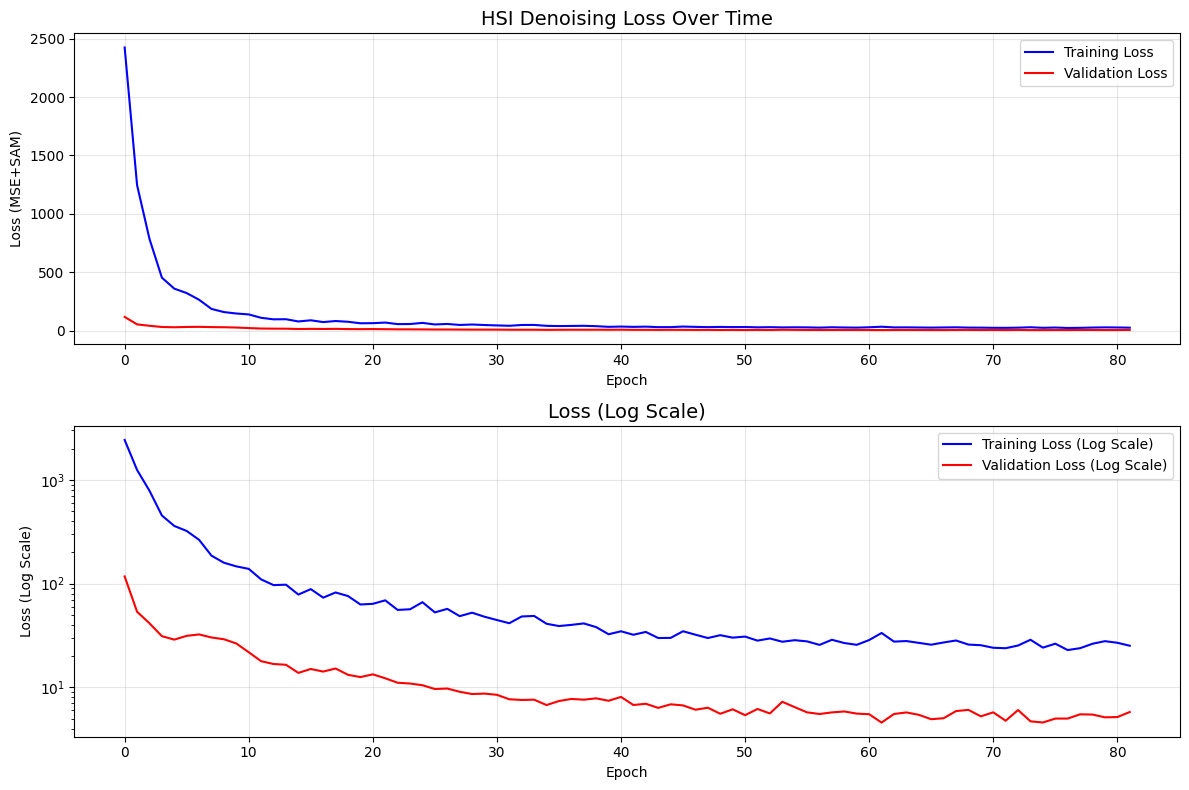


Training Statistics:
  Minimum Train Loss: 22.878671 at epoch 77
  Minimum Val Loss: 4.572767 at epoch 62
  Final Train Loss: 25.181800
  Final Val Loss: 5.781788
Loading patches...
Loaded patches shape: (30, 191, 32, 32)
Loaded patches shape: (30, 191, 32, 32)
Processed tensor shapes: torch.Size([30, 1, 32, 191, 32])
Noisy - min: 0.0000, max: 1.0000
Clean - min: 0.0000, max: 1.0000
Visualization saved at: ./hsi_pipeline_models/pipeline_visualization_trial2.png


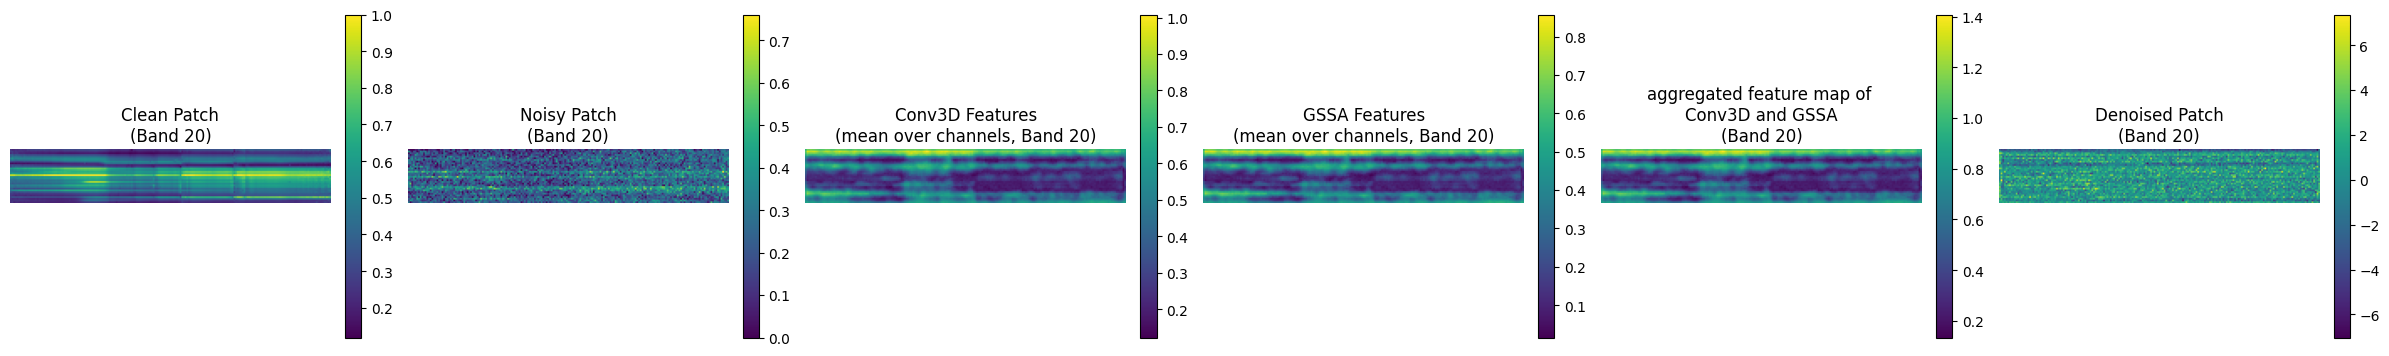


Analysis Complete! Generated Files:
Models: ./hsi_pipeline_models/hsi_denoising_pipeline.pth
Best model: ./hsi_pipeline_models/best_model.pth
Training curve: ./hsi_pipeline_models/training_curve.png
Final metrics: ./hsi_pipeline_models/final_metrics.npy
Training and analysis completed successfully!


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import time
import os
import gc
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from einops import rearrange
import random
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.image import StructuralSimilarityIndexMeasure

# Import custom modules (assumed to be in the same directory)
from Conv3d_patch import SpectralSpatialConv3D
from gssa_attention_module import GSSA
from dense3D import ResidualConv3DProgressiveRefinement

def free_gpu_memory():
    """Force clear GPU memory in PyTorch (especially useful in Jupyter)."""
    gc.collect()                      # Clear Python garbage
    torch.cuda.empty_cache()          # Clear PyTorch cache
    torch.cuda.ipc_collect()          # Collect inter-process memory (helps in Jupyter)
    print("GPU memory cleared.")

# Call this at the start of your script / cell
free_gpu_memory()

def spectral_angle_mapper(y_true, y_pred, eps=1e-8):
    """Compute Spectral Angle Mapper (SAM) loss between true and predicted spectra."""
    y_true_norm = y_true / (torch.norm(y_true, dim=-1, keepdim=True) + eps)
    y_pred_norm = y_pred / (torch.norm(y_pred, dim=-1, keepdim=True) + eps)
    cos_sim = torch.clamp(torch.sum(y_true_norm * y_pred_norm, dim=-1), -1.0, 1.0)
    sam = torch.acos(cos_sim).mean()
    return sam

def compute_psnr(y_true, y_pred, max_pixel=None):
    """Compute Peak Signal-to-Noise Ratio (PSNR)."""
    # Validate max_pixel based on input data range
    if max_pixel is None:
        max_pixel = torch.max(torch.abs(y_true)).item()
        if max_pixel == 0:
            max_pixel = 1.0  # Fallback to 1.0 if data range is zero
    mse = torch.mean((y_true - y_pred) ** 2)
    if mse == 0:
        return 100.0  # Return large finite value instead of inf
    return 20 * torch.log10(max_pixel / torch.sqrt(mse)).item()

def compute_ssim(y_true, y_pred, device, data_range=1.0):
    """Compute Structural Similarity Index (SSIM)."""
    ssim_metric = StructuralSimilarityIndexMeasure(data_range=data_range).to(device)
    return ssim_metric(y_true, y_pred).item()

def compute_sam_np(y_true, y_pred, eps=1e-8):
    """Compute SAM metric for numpy arrays."""
    y_true_norm = y_true / (np.linalg.norm(y_true, axis=-1, keepdims=True) + eps)
    y_pred_norm = y_pred / (np.linalg.norm(y_pred, axis=-1, keepdims=True) + eps)
    cos_sim = np.clip(np.sum(y_true_norm * y_pred_norm, axis=-1), -1.0, 1.0)
    sam = np.mean(np.arccos(cos_sim))
    return sam

class HSIDenoisingDataset(Dataset):
    """Dataset for HSI denoising with normalization and augmentation."""
    
    def __init__(self, noisy_patches, clean_patches, augment=True, flip_prob=0.5, shuffle_prob=0.3):
        """
        Args:
            noisy_patches: Tensor of shape (N, 1, H, W, D) - noisy input patches
            clean_patches: Tensor of shape (N, 1, H, W, D) - clean ground truth patches
            augment: Whether to apply data augmentation
            flip_prob: Probability of spatial flips
            shuffle_prob: Probability of spectral band shuffling
        """
        self.noisy_patches = noisy_patches
        self.clean_patches = clean_patches
        self.augment = augment
        self.flip_prob = flip_prob
        self.shuffle_prob = shuffle_prob
        
        # Validate dimensions
        assert noisy_patches.shape == clean_patches.shape, \
            f"Shape mismatch: noisy {noisy_patches.shape} vs clean {clean_patches.shape}"
        
        # Normalize patches to [0, 1]
        self.noisy_patches = self._normalize(self.noisy_patches)
        self.clean_patches = self._normalize(self.clean_patches)
    
    def _normalize(self, patches):
        """Normalize patches to [0, 1] using min-max scaling."""
        min_val = torch.amin(patches, dim=(0, 1, 2, 3), keepdim=True)
        max_val = torch.amax(patches, dim=(0, 1, 2, 3), keepdim=True)
        return (patches - min_val) / (max_val - min_val + 1e-8)
    
    def _augment(self, noisy, clean):
        """Apply data augmentation: spatial flips and spectral band shuffling."""
        if not self.augment:
            return noisy, clean
        
        # Random horizontal flip
        if random.random() < self.flip_prob:
            noisy = torch.flip(noisy, dims=[2])
            clean = torch.flip(clean, dims=[2])
        
        # Random vertical flip
        if random.random() < self.flip_prob:
            noisy = torch.flip(noisy, dims=[3])
            clean = torch.flip(clean, dims=[3])
        
        # Random spectral band shuffling
        if random.random() < self.shuffle_prob:
            indices = torch.randperm(noisy.shape[-1])
            noisy = noisy[..., indices]
            clean = clean[..., indices]
        
        return noisy, clean
    
    def __len__(self):
        return len(self.noisy_patches)
    
    def __getitem__(self, idx):
        noisy, clean = self.noisy_patches[idx], self.clean_patches[idx]
        if self.augment:
            noisy, clean = self._augment(noisy, clean)
        return noisy, clean

class HSIDenoisingPipeline(nn.Module):
    """Complete HSI Denoising Pipeline combining Conv3D, GSSA, and Dense3D."""
    
    def __init__(self, conv3d_channels=64, spectral_bands=191, dropout=0.1, use_residual=True):
        """
        Args:
            conv3d_channels: Number of channels in Conv3D feature extractor
            spectral_bands: Number of spectral bands
            dropout: Dropout rate
            use_residual: Whether to add residual connection to input
        """
        super(HSIDenoisingPipeline, self).__init__()
        self.use_residual = use_residual
        
        # Stage 1: Conv3D Feature Extraction
        self.conv3d_extractor = SpectralSpatialConv3D(
            in_channels=1, 
            out_channels=conv3d_channels, 
            dropout=0.1
        )
        
        # Stage 2: GSSA Attention Mechanism
        self.gssa_attention = GSSA(
            channel=conv3d_channels,
            num_bands=spectral_bands,
            flex=False
        )
        
        # Stage 3: Progressive Refinement and Denoising
        self.progressive_denoiser = ResidualConv3DProgressiveRefinement(
            in_channels=conv3d_channels,
            out_channels=1,
            dropout=dropout,
            use_groupnorm=True
        )
    
    def forward(self, x):
        """
        Forward pass through the pipeline.
        
        Args:
            x: Input tensor of shape (B, 1, H, W, D) - noisy HSI patches
            
        Returns:
            denoised: Output tensor of shape (B, 1, H, W, D) - denoised patches
            attention_maps: Attention weights from GSSA
        """
        # Stage 1: Conv3D Feature Extraction
        conv3d_features = self.conv3d_extractor(x)  # (B, C, H, W, D)
        
        # Stage 2: GSSA Attention Processing
        gssa_features, attention_maps = self.gssa_attention(conv3d_features)  # (B, C, H, W, D)
        
        # Stage 3: Progressive Refinement
        denoised, aggregated = self.progressive_denoiser(conv3d_features, gssa_features)  # (B, 1, H, W, D)
        
        # Residual connection
        if self.use_residual:
            denoised = x + denoised
        
        return denoised, attention_maps

class HSIDenoisingTrainer:
    """Complete HSI Denoising Training Pipeline."""
    
    def __init__(self, 
                 noisy_mat_path,
                 clean_mat_path,
                 device='auto',
                 learning_rate=1e-3,
                 batch_size=4,
                 num_epochs=1,
                 patch_key='patches',
                 clean_patch_key='patches',
                 save_dir='./trained_models',
                 conv3d_channels=64,
                 dropout=0.1,
                 mse_weight=1.0,
                 sam_weight=0.1,
                 early_stopping_patience=20,
                 val_split=0.2):
        """
        Args:
            noisy_mat_path: Path to noisy patches .mat file
            clean_mat_path: Path to clean patches .mat file
            device: 'auto', 'cuda', 'mps', or 'cpu'
            learning_rate: Initial learning rate
            batch_size: Batch size for training
            num_epochs: Number of training epochs
            patch_key: Key for noisy patches in .mat file
            clean_patch_key: Key for clean patches in .mat file
            save_dir: Directory to save models and results
            conv3d_channels: Number of Conv3D channels
            dropout: Dropout rate
            mse_weight: Weight for MSE loss
            sam_weight: Weight for SAM loss
            early_stopping_patience: Epochs to wait for validation loss improvement
            val_split: Fraction of data to use for validation
        """
        self.noisy_mat_path = noisy_mat_path
        self.clean_mat_path = clean_mat_path
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.patch_key = patch_key
        self.clean_patch_key = clean_patch_key
        self.save_dir = save_dir
        self.conv3d_channels = conv3d_channels
        self.dropout = dropout
        self.mse_weight = mse_weight
        self.sam_weight = sam_weight
        self.early_stopping_patience = early_stopping_patience
        self.val_split = val_split
        
        # Set device
        self.device = self._setup_device(device)
        print(f"Using device: {self.device}")
        
        # Initialize components
        self.model = None
        self.optimizer = None
        self.scheduler = None
        self.criterion_mse = None
        self.train_losses = []
        self.val_losses = []
        self.best_val_loss = float('inf')
        self.patience_counter = 0
        self.current_lr = self.learning_rate
        
        # Create save directory
        os.makedirs(save_dir, exist_ok=True)
    
    def _setup_device(self, device):
        """Setup computation device."""
        if device == 'auto':
            if torch.cuda.is_available():
                return torch.device('cuda')
            elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
                return torch.device('mps')
            else:
                return torch.device('cpu')
        else:
            return torch.device(device)
    
    def load_patches(self):
        """Load and preprocess patches from .mat files with lazy loading support."""
        print("Loading patches...")
        
        def load_mat_patches(mat_path, key):
            try:
                data = sio.loadmat(mat_path)
                if key in data:
                    patches = data[key]
                else:
                    possible_keys = ['patches', 'data', 'patch_data', 'hsi_patches']
                    found_key = None
                    for k in possible_keys:
                        if k in data:
                            found_key = k
                            break
                    if found_key:
                        patches = data[found_key]
                        print(f"Found patches under key: '{found_key}' in {mat_path}")
                    else:
                        available_keys = [k for k in data.keys() if not k.startswith('__')]
                        raise KeyError(f"Key '{key}' not found. Available: {available_keys}")
                
                print(f"Loaded patches shape: {patches.shape}")
                return patches
            except Exception as e:
                raise RuntimeError(f"Error loading {mat_path}: {e}")
        
        # Load patches
        noisy_patches = load_mat_patches(self.noisy_mat_path, self.patch_key)
        clean_patches = load_mat_patches(self.clean_mat_path, self.clean_patch_key)
        
        # Validate shapes
        if noisy_patches.shape != clean_patches.shape:
            raise ValueError(f"Shape mismatch: noisy {noisy_patches.shape} vs clean {clean_patches.shape}")
        
        # Convert to tensor
        def process_patches(patches):
            if len(patches.shape) == 4:
                if patches.shape[-1] < patches.shape[1]:  # spectral dimension is last
                    patches = np.transpose(patches, (0, 3, 1, 2))
                tensor = torch.from_numpy(patches).float().unsqueeze(1)  # (N, 1, H, W, D)
                return tensor
            else:
                raise ValueError(f"Expected 4D patch array, got shape: {patches.shape}")
        
        noisy_tensor = process_patches(noisy_patches)
        clean_tensor = process_patches(clean_patches)
        
        print(f"Processed tensor shapes: {noisy_tensor.shape}")
        
        # Validate tensors
        for name, tensor in [("Noisy", noisy_tensor), ("Clean", clean_tensor)]:
            if torch.isnan(tensor).any():
                raise ValueError(f"{name} tensor contains NaN values")
            if torch.isinf(tensor).any():
                raise ValueError(f"{name} tensor contains infinite values")
            print(f"{name} - min: {tensor.min():.4f}, max: {tensor.max():.4f}")
        
        return noisy_tensor, clean_tensor
    
    def initialize_model(self, sample_input):
        """Initialize the pipeline model."""
        print("Initializing HSI Denoising Pipeline...")
        
        # Get dimensions
        batch_size, channels, height, width, spectral_bands = sample_input.shape
        print(f"Input dimensions: B={batch_size}, C={channels}, H={height}, W={width}, D={spectral_bands}")
        
        # Initialize pipeline
        self.model = HSIDenoisingPipeline(
            conv3d_channels=self.conv3d_channels,
            spectral_bands=spectral_bands,
            dropout=self.dropout,
            use_residual=True
        ).to(self.device)
        
        # Test forward pass
        with torch.no_grad():
            test_input = sample_input[:1].to(self.device)
            test_output, test_attention = self.model(test_input)
            print(f"Pipeline test - Input: {test_input.shape}, Output: {test_output.shape}")
            print(f"Attention maps shape: {test_attention.shape}")
        
        print("Pipeline initialized successfully!")
    
    def setup_training(self):
        """Setup optimizer, scheduler, and loss functions."""
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=0.5, patience=5)
        self.criterion_mse = nn.MSELoss()
        print(f"Training setup - Optimizer: Adam, LR: {self.learning_rate}, Loss: MSE+SAM")
    
    def train_epoch(self, dataloader, is_train=True):
        """Train or validate for one epoch."""
        mode = 'train' if is_train else 'val'
        self.model.train() if is_train else self.model.eval()
        epoch_loss = 0.0
        epoch_mse = 0.0
        epoch_sam = 0.0
        num_batches = 0
        
        with torch.set_grad_enabled(is_train):
            for noisy_batch, clean_batch in dataloader:
                noisy_batch = noisy_batch.to(self.device)
                clean_batch = clean_batch.to(self.device)
                
                if is_train:
                    self.optimizer.zero_grad()
                
                denoised_output, _ = self.model(noisy_batch)
                
                mse_loss = self.criterion_mse(denoised_output, clean_batch)
                sam_loss = spectral_angle_mapper(clean_batch, denoised_output)
                loss = self.mse_weight * mse_loss + self.sam_weight * sam_loss
                
                if is_train:
                    loss.backward()
                    self.optimizer.step()
                
                epoch_loss += loss.item()
                epoch_mse += mse_loss.item()
                epoch_sam += sam_loss.item()
                num_batches += 1
                
                if self.device.type == 'cuda':
                    torch.cuda.empty_cache()
        
        avg_loss = epoch_loss / num_batches
        avg_mse = epoch_mse / num_batches
        avg_sam = epoch_sam / num_batches
        return avg_loss, avg_mse, avg_sam
    
    def train(self):
        """Main training loop with validation."""
        print("=" * 60)
        print("Starting HSI Denoising Pipeline Training")
        print("=" * 60)
        
        # Load data
        noisy_patches, clean_patches = self.load_patches()
        
        # Initialize model
        self.initialize_model(noisy_patches)
        
        # Setup training
        self.setup_training()
        
        # Create dataset
        dataset = HSIDenoisingDataset(noisy_patches, clean_patches, augment=True)
        
        # Train/validation split
        dataset_size = len(dataset)
        indices = list(range(dataset_size))
        random.shuffle(indices)
        split = int(self.val_split * dataset_size)
        train_indices, val_indices = indices[split:], indices[:split]
        
        train_sampler = SubsetRandomSampler(train_indices)
        val_sampler = SubsetRandomSampler(val_indices)
        
        train_loader = DataLoader(dataset, batch_size=self.batch_size, sampler=train_sampler, 
                                num_workers=min(os.cpu_count(), 4), pin_memory=True)
        val_loader = DataLoader(dataset, batch_size=self.batch_size, sampler=val_sampler, 
                              num_workers=min(os.cpu_count(), 4), pin_memory=True)
        
        print(f"Training Configuration:")
        print(f"  - Dataset size: {len(dataset)} patches")
        print(f"  - Train/Val split: {len(train_indices)}/{len(val_indices)}")
        print(f"  - Batch size: {self.batch_size}")
        print(f"  - Number of epochs: {self.num_epochs}")
        print(f"  - Learning rate: {self.learning_rate}")
        print(f"  - MSE/SAM weights: {self.mse_weight}/{self.sam_weight}")
        print("-" * 60)
        
        # Training loop
        start_time = time.time()
        
        for epoch in range(self.num_epochs):
            epoch_start_time = time.time()
            
            # Train
            train_loss, train_mse, train_sam = self.train_epoch(train_loader, is_train=True)
            self.train_losses.append(train_loss)
            
            # Validate
            val_loss, val_mse, val_sam = self.train_epoch(val_loader, is_train=False)
            self.val_losses.append(val_loss)
            
            # Update learning rate
            self.scheduler.step(val_loss)
            current_lr = self.optimizer.param_groups[0]['lr']
            if current_lr != self.current_lr:
                print(f"Learning rate reduced to {current_lr:.6f}")
                self.current_lr = current_lr
            
            # Save best model
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.save_checkpoint(epoch + 1, is_best=True)
                self.patience_counter = 0
            else:
                self.patience_counter += 1
            
            # Print progress
            epoch_time = time.time() - epoch_start_time
            elapsed_time = time.time() - start_time
            print(f"Epoch [{epoch+1:3d}/{self.num_epochs}] | "
                  f"Train Loss: {train_loss:.6f} (MSE: {train_mse:.6f}, SAM: {train_sam:.6f}) | "
                  f"Val Loss: {val_loss:.6f} (MSE: {val_mse:.6f}, SAM: {val_sam:.6f}) | "
                  f"Time: {epoch_time:.2f}s | "
                  f"Total: {elapsed_time/60:.1f}min")
            
            # Save checkpoint every 10 epochs
            if (epoch + 1) % 10 == 0:
                self.save_checkpoint(epoch + 1)
            
            # Early stopping
            if self.patience_counter >= self.early_stopping_patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break
            
            # Memory cleanup
            if (epoch + 1) % 5 == 0:
                gc.collect()
                if self.device.type == 'cuda':
                    torch.cuda.empty_cache()
        
        total_time = time.time() - start_time
        print("-" * 60)
        print(f"Training completed in {total_time/60:.2f} minutes")
        print(f"Final train loss: {self.train_losses[-1]:.6f}")
        print(f"Best val loss: {self.best_val_loss:.6f}")
        
        # Compute PSNR, SSIM, and SAM on validation set
        self.model.eval()
        val_psnr = []
        val_ssim = []
        val_sam = []
        with torch.no_grad():
            for noisy_batch, clean_batch in val_loader:
                noisy_batch = noisy_batch.to(self.device)
                clean_batch = clean_batch.to(self.device)
                denoised_output, _ = self.model(noisy_batch)
                val_psnr.append(compute_psnr(clean_batch, denoised_output))
                val_ssim.append(compute_ssim(clean_batch, denoised_output, self.device))
                val_sam.append(spectral_angle_mapper(clean_batch, denoised_output).item())
        
        avg_psnr = np.mean(val_psnr)
        avg_ssim = np.mean(val_ssim)
        avg_sam = np.mean(val_sam)
        print(f"Validation Metrics:")
        print(f"  PSNR: {avg_psnr:.2f} dB")
        print(f"  SSIM: {avg_ssim:.4f}")
        print(f"  SAM: {avg_sam:.4f} radians")
        
        # Save metrics
        np.save(f"{self.save_dir}/final_metrics.npy", {
            'psnr': avg_psnr,
            'ssim': avg_ssim,
            'sam': avg_sam,
            'train_losses': np.array(self.train_losses),
            'val_losses': np.array(self.val_losses)
        })
        
        # Save final model
        self.save_model()
        
        return self.train_losses, self.val_losses, avg_psnr, avg_ssim, avg_sam
    
    def save_checkpoint(self, epoch, is_best=False):
        """Save training checkpoint."""
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
        }
        path = f"{self.save_dir}/checkpoint_epoch_{epoch}.pth"
        if is_best:
            path = f"{self.save_dir}/best_model.pth"
        torch.save(checkpoint, path)
        print(f"{'Best model' if is_best else 'Checkpoint'} saved at {path}")
    
    def save_model(self):
        """Save final trained model."""
        torch.save(self.model.state_dict(), f"{self.save_dir}/hsi_denoising_pipeline.pth")
        np.save(f"{self.save_dir}/training_losses.npy", np.array(self.train_losses))
        np.save(f"{self.save_dir}/validation_losses.npy", np.array(self.val_losses))
        print(f"Final model saved to {self.save_dir}")
    
    def load_model(self, model_path):
        """Load a trained model."""
        if self.model is None:
            raise RuntimeError("Model not initialized. Call initialize_model() first.")
        self.model.load_state_dict(torch.load(model_path, map_location=self.device))
        print(f"Model loaded from {model_path}")
    
    def denoise_patches(self, input_patches, output_path="denoised_patches.mat"):
        """Apply trained model to denoise patches."""
        self.model.eval()
        dataset = HSIDenoisingDataset(input_patches, input_patches, augment=False)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False, 
                              num_workers=min(os.cpu_count(), 4), pin_memory=True)
        
        denoised_patches = []
        attention_maps = []
        
        with torch.no_grad():
            for batch_idx, (noisy_batch, _) in enumerate(dataloader):
                noisy_batch = noisy_batch.to(self.device)
                denoised_output, batch_attention = self.model(noisy_batch)
                denoised_patches.append(denoised_output.cpu())
                attention_maps.append(batch_attention.cpu())
                print(f"Processed batch {batch_idx + 1}/{len(dataloader)}")
        
        denoised_patches = torch.cat(denoised_patches, dim=0)
        attention_maps = torch.cat(attention_maps, dim=0)
        
        print(f"Debug - Combined denoised shape: {denoised_patches.shape}")
        
        # Convert to numpy: (B, 1, H, W, D) -> (B, H, W, D)
        denoised_numpy = denoised_patches.squeeze(1).numpy()
        attention_numpy = attention_maps.numpy()
        
        print(f"Debug - Final denoised numpy shape: {denoised_numpy.shape}")
        
        sio.savemat(output_path, {
            'denoised_patches': denoised_numpy,
            'attention_maps': attention_numpy
        })
        
        print(f"Denoised patches saved to: {output_path}")
        return denoised_numpy, attention_numpy

    def visualize_pipeline(self, sample_index=0, save_path=None):
        """
        Visualize the full HSI denoising pipeline stages on one sample patch:
        clean patch -> noisy patch -> conv3d features -> GSSA features -> denoised patch.
        """
        import matplotlib.pyplot as plt
        import numpy as np
        
        # Load patches (assuming they're tensors: [N, 1, H, W, D])
        noisy_patches, clean_patches = self.load_patches()
        
        # Select sample and move to device
        sample_clean = clean_patches[sample_index].unsqueeze(0).to(self.device)  # (1,1,H,W,D)
        sample_noisy = noisy_patches[sample_index].unsqueeze(0).to(self.device)  # (1,1,H,W,D)
        
        self.model.eval()
        with torch.no_grad():
            # Conv3D feature extraction (output shape: (1, C, H, W, D))
            conv3d_features = self.model.conv3d_extractor(sample_noisy)
            
            # GSSA attention features (output shape: (1, C, H, W, D))
            gssa_features, attention_maps = self.model.gssa_attention(conv3d_features)
            
            # Denoised patch (output shape: (1, 1, H, W, D))
            denoised, aggregated = self.model.progressive_denoiser(conv3d_features, gssa_features)
            if self.model.use_residual:
                denoised = sample_noisy + denoised
        
        # Convert tensors to numpy arrays (remove batch and channel dims)
        sample_clean_np = sample_clean.squeeze(0).squeeze(0).cpu().numpy()   # (H,W,D)
        sample_noisy_np = sample_noisy.squeeze(0).squeeze(0).cpu().numpy()   # (H,W,D)
        conv3d_np = conv3d_features.squeeze(0).cpu().numpy()                 # (C,H,W,D)
        gssa_np = gssa_features.squeeze(0).cpu().numpy()                     # (C,H,W,D)
        denoised_np = denoised.squeeze(0).squeeze(0).cpu().numpy()           # (H,W,D)
        aggregated_np = aggregated.squeeze(0).cpu().numpy()   
        
        # Choose band index for visualization
        band_idx = 20
        max_band = sample_clean_np.shape[2] - 1
        if band_idx > max_band:
            band_idx = max_band
        
        # For Conv3D and GSSA features, select a representative channel or mean over channels at band_idx
        # Here, we average over channels at band_idx slice
        conv3d_feature_map = conv3d_np[:, :, :, band_idx].mean(axis=0)  # shape: (H,W)
        gssa_feature_map = gssa_np[:, :, :, band_idx].mean(axis=0)      # shape: (H,W)
        aggregated_feature_map = aggregated_np[:,:,:,band_idx].mean(axis=0)
        
        def show_img(ax, img, title):
            im = ax.imshow(img, cmap='viridis')
            ax.set_title(title)
            ax.axis('off')
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        
        # Plot layout: 1 row, 5 columns
        fig, axs = plt.subplots(1, 6, figsize=(24, 8))
        
        show_img(axs[0], sample_clean_np[:, :, band_idx], f'Clean Patch\n(Band {band_idx})')
        show_img(axs[1], sample_noisy_np[:, :, band_idx], f'Noisy Patch\n(Band {band_idx})')
        show_img(axs[2], conv3d_feature_map, f'Conv3D Features\n(mean over channels, Band {band_idx})')
        show_img(axs[3], gssa_feature_map, f'GSSA Features\n(mean over channels, Band {band_idx})')
        show_img(axs[4], aggregated_feature_map, f'aggregated feature map of \nConv3D and GSSA\n(Band {band_idx})')
        show_img(axs[5], denoised_np[:, :, band_idx], f'Denoised Patch\n(Band {band_idx})')
        
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Visualization saved at: {save_path}")
        plt.show()


    
    def plot_training_curve(self):
        """Plot training and validation loss curves."""
        if not self.train_losses or not self.val_losses:
            print("No training history available")
            return
        
        plt.figure(figsize=(12, 8))
        
        # Main loss curve
        plt.subplot(2, 1, 1)
        plt.plot(self.train_losses, 'b-', label='Training Loss')
        plt.plot(self.val_losses, 'r-', label='Validation Loss')
        plt.title('HSI Denoising Loss Over Time', fontsize=14)
        plt.xlabel('Epoch')
        plt.ylabel('Loss (MSE+SAM)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Log scale
        plt.subplot(2, 1, 2)
        plt.semilogy(self.train_losses, 'b-', label='Training Loss (Log Scale)')
        plt.semilogy(self.val_losses, 'r-', label='Validation Loss (Log Scale)')
        plt.title('Loss (Log Scale)', fontsize=14)
        plt.xlabel('Epoch')
        plt.ylabel('Loss (Log Scale)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(f"{self.save_dir}/training_curve.png", dpi=300, bbox_inches='tight')
        plt.show()
        
        # Print statistics
        min_train_loss = min(self.train_losses)
        min_val_loss = min(self.val_losses)
        min_train_epoch = self.train_losses.index(min_train_loss) + 1
        min_val_epoch = self.val_losses.index(min_val_loss) + 1
        
        print(f"\nTraining Statistics:")
        print(f"  Minimum Train Loss: {min_train_loss:.6f} at epoch {min_train_epoch}")
        print(f"  Minimum Val Loss: {min_val_loss:.6f} at epoch {min_val_epoch}")
        print(f"  Final Train Loss: {self.train_losses[-1]:.6f}")
        print(f"  Final Val Loss: {self.val_losses[-1]:.6f}")

if __name__ == "__main__":
    # Configuration
    config = {
        # 'noisy_mat_path': '/Users/muhtasimishmumkhan/Desktop/499/hsi/hybArch/HSI_denoising/init/noisy_patches/train_Wash2_patches_noisy.mat',
        # 'clean_mat_path': '/Users/muhtasimishmumkhan/Desktop/499/hsi/hybArch/HSI_denoising/saved_patches/train_Wash2_patches.mat',
        'noisy_mat_path': '/home/habib/Documents/workspace/hsi_enoising_hybrid/HSI_denoising/init/noisy_patches/train_Wash2_patches_noisy.mat',
        'clean_mat_path': '/home/habib/Documents/workspace/hsi_enoising_hybrid/HSI_denoising/saved_patches/train_Wash2_patches.mat',
        'device': 'auto',
        'learning_rate': 1e-3,
        'batch_size': 8,
        'num_epochs': 100,
        'patch_key': 'patches',
        'clean_patch_key': 'patches',
        'save_dir': './hsi_pipeline_models',
        'conv3d_channels': 64,
        'dropout': 0.1,
        'mse_weight': 1.0,
        'sam_weight': 0.1,
        'early_stopping_patience': 20,
        'val_split': 0.2
    }
    
    # Initialize and train
    trainer = HSIDenoisingTrainer(**config)
    train_losses, val_losses, final_psnr, final_ssim, final_sam = trainer.train()
    
    # Post-training analysis
    print("\n" + "="*60)
    print("Starting Post-Training Analysis")
    print("="*60)
    
    # Plot training curve
    trainer.plot_training_curve()
    # Visualize the denoising pipeline for a sample patch
    trainer.visualize_pipeline(sample_index=0, save_path=f"{config['save_dir']}/pipeline_visualization.png")

    print("\n" + "="*60)
    print("Analysis Complete! Generated Files:")
    print("="*60)
    print(f"Models: {config['save_dir']}/hsi_denoising_pipeline.pth")
    print(f"Best model: {config['save_dir']}/best_model.pth")
    print(f"Training curve: {config['save_dir']}/training_curve.png")
    print(f"Final metrics: {config['save_dir']}/final_metrics.npy")
    print("="*60)
    print("Training and analysis completed successfully!")